In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 145 ms


In [3]:
os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/01102018_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 118 ms


In [4]:
preImp= pd.read_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/22112018_worstdf2_preImp.csv")
preImp= pd.merge(preImp, final_pt_df2[['icustay_id','final_bin','subject_id']])

time: 73.4 ms


In [5]:
#'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst%d.txt'

date= '14112018'
os.chdir(r'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/')
allFiles = glob.glob(os.getcwd() + "/{}**.csv".format("training_worst"))
allFiles

['/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst9.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst8.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst20.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst18.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst19.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst17.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst16.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst14.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst15.csv',
 '/Users/geickelb1/Documents/GitHub/mim

time: 5.9 ms


In [6]:
#making a concatenated dataframe of all imputed 
df_list=[]
for element in allFiles:
    df_list.append(element.split('training_'.format(date))[1].split('.csv')[0]) #making an list of all my dataframes in order they appear in file
#print(sorted(df_list)) 
# dfs = {}
i=0

imputeCat_df= pd.read_csv(allFiles[0])#, index_col=0)
for name in df_list[1:]:
    imputeCat_df= pd.concat([imputeCat_df, pd.read_csv(allFiles[i])])
    #dfs[name] = pd.read_csv(allFiles[i],  index_col=0)
    i+=1

#get rid of an unnamed column
imputeCat_df= imputeCat_df.iloc[:,1:]

time: 2.27 s


In [7]:
#checking pt #'s

# print(len(patients), len(icustay_id))

# print(5446/7778)
print(preImp['icustay_id'].nunique(), preImp['subject_id'].nunique())
print(imputeCat_df['icustay_id'].nunique(), imputeCat_df['subject_id'].nunique()) #good the test set partitioning worked

7778 6994
5446 5012
time: 7.76 ms


# aggregation

In [8]:
imputeMean_df= imputeCat_df.groupby("icustay_id").mean()

time: 83.6 ms


In [9]:
#the aggregation dropped some columns (categorical), so we will add them back in based on the first imputed file (since they will all be the same)
print(len(list(imputeCat_df)),len(list(imputeMean_df)))
print(set(imputeCat_df)-set(imputeMean_df))

firstImpute_temp= pd.read_csv(allFiles[0])#, index_col=0)
missing_list= list(set(imputeCat_df)-set(imputeMean_df))
imputeMean_df= pd.merge(imputeMean_df.reset_index(), firstImpute_temp[missing_list], left_on='icustay_id', right_on='icustay_id')
del(missing_list, firstImpute_temp)

48 41
{'final_bin', 'icustay_id', 'gender', 'leukocyte', 'ethnicity', 'vent_recieved', 'nitrite'}
time: 50.7 ms


In [10]:
list(set(imputeCat_df)-set(imputeMean_df))
print(len(list(imputeMean_df)), len(list(imputeCat_df))) #good, both have same # of columns

48 48
time: 1.71 ms


In [11]:
#impute range
imputeCat_df.groupby("icustay_id").agg(lambda x: max(x)-min(x))

,bandsNum,bilirubin,bun,chloride,creatinine,daily_sofa,dobutamine,dopamine,epinephrine,first_admit_age,...,platelet,spo2,sysbp,maxCalcium,maxSodium,maxWBC,minCalcium,minSodium,minWBC,subject_id
icustay_id,,,,,,,,,,,,,,,,,,,,,
200014,22.0,5.9,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.00,0,0.0,0.00,0,0.0,0
200030,36.0,0.0,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.00,0,0.0,0.00,0,0.0,0
200033,23.0,2.0,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.00,0,0.0,0.00,0,0.0,0
200036,28.0,6.2,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.41,0,0.0,0.28,0,0.0,0
200055,34.0,0.0,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.00,0,0.0,0.00,0,0.0,0
200059,59.0,0.0,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.00,0,0.0,0.00,0,0.0,0
200061,22.0,0.0,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.16,0,0.0,0.37,0,0.0,0
200075,23.0,0.0,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.33,0,0.0,0.31,0,0.0,0
200091,23.0,0.0,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.00,0,0.0,0.00,0,0.0,0


time: 5.89 s


In [12]:
preImp['bands'].describe()

count    1118.000000
mean       10.337835
std        10.662087
min         1.000000
25%         3.000000
50%         6.000000
75%        14.000000
max        73.000000
Name: bands, dtype: float64

time: 8.4 ms


# QC: 
* how well did imputation perform?
* is averaging the imputed values the best option?


### bands

In [13]:
#before imputation
preImp['bands'].describe()

count    1118.000000
mean       10.337835
std        10.662087
min         1.000000
25%         3.000000
50%         6.000000
75%        14.000000
max        73.000000
Name: bands, dtype: float64

time: 5.9 ms


In [14]:
#after imputation
imputeCat_df['bandsNum'].describe() #5446 rows. so all 20 should have ~100k

count    108920.000000
mean          8.184322
std           8.890501
min           1.000000
25%           2.000000
50%           5.000000
75%          11.000000
max          73.000000
Name: bandsNum, dtype: float64

time: 14 ms


In [15]:
#impute mean aggregate
imputeMean_df['bandsNum'].describe()

count    5446.000000
mean        8.184322
std         5.037581
min         1.000000
25%         5.411250
50%         7.150000
75%         9.550000
max        73.000000
Name: bandsNum, dtype: float64

time: 5.77 ms


In [16]:
preImp['bands'].describe()- imputeCat_df['bandsNum'].describe() 
#overall the difference between the distributions isn't very large. the mean went down by 2.

count   -107802.000000
mean          2.153513
std           1.771586
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max           0.000000
dtype: float64

time: 17.1 ms


#### what happens if we groupby outcome and look at distribution?

                 count       mean        std  min  25%  50%   75%   max
final_bin                                                              
C_neg/A_partial  583.0   7.942367   8.683094  1.0  2.0  5.0  11.0  73.0
C_pos/A_full     535.0  12.948224  11.938447  1.0  4.0  9.0  18.0  71.0
final_bin
C_neg/A_partial    AxesSubplot(0.125,0.125;0.775x0.755)
C_pos/A_full       AxesSubplot(0.125,0.125;0.775x0.755)
Name: bands, dtype: object


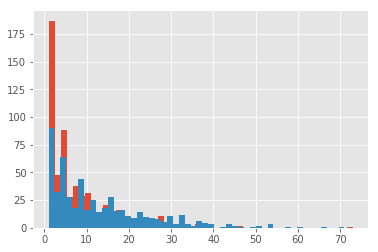

time: 316 ms


In [17]:
#before imputation
print(preImp.groupby("final_bin")['bands'].describe())
print(preImp.groupby("final_bin")['bands'].hist(bins=50))

                   count      mean        std  min  25%  50%   75%   max
final_bin                                                               
C_neg/A_partial  80880.0  7.565054   8.186423  1.0  2.0  5.0  10.0  73.0
C_pos/A_full     28040.0  9.970571  10.460820  1.0  2.0  6.0  14.0  73.0
final_bin
C_neg/A_partial    AxesSubplot(0.125,0.125;0.775x0.755)
C_pos/A_full       AxesSubplot(0.125,0.125;0.775x0.755)
Name: bandsNum, dtype: object


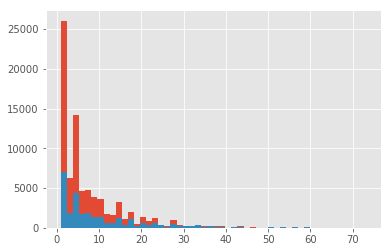

time: 277 ms


In [18]:
#after imputation
print(imputeCat_df.groupby("final_bin")['bandsNum'].describe())
print(imputeCat_df.groupby("final_bin")['bandsNum'].hist(bins=50))

                  count      mean       std  min    25%   50%     75%   max
final_bin                                                                  
C_neg/A_partial  4044.0  7.565054  3.797362  1.0  5.315  6.92   9.090  73.0
C_pos/A_full     1402.0  9.970571  7.260569  1.0  5.800  8.05  11.495  60.0
final_bin
C_neg/A_partial    AxesSubplot(0.125,0.125;0.775x0.755)
C_pos/A_full       AxesSubplot(0.125,0.125;0.775x0.755)
Name: bandsNum, dtype: object


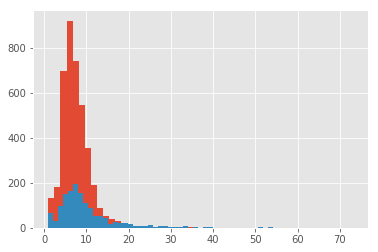

time: 247 ms


In [19]:
#impute mean aggregate
print(imputeMean_df.groupby("final_bin")['bandsNum'].describe())
print(imputeMean_df.groupby("final_bin")['bandsNum'].hist(bins=50))

### so this is noteworthy, the distribution did shift from being left sided to centered. is this an issue?

### overall,it appears the imputation went pretty well.
* the positive mean went up about 30%, while the sd rose ~15%. overall it doesn't look like the values deviated very far.
* the max value 
* the c_neg/A_partial imputation remained extremely stable. 
* pooling the means of imputation does however shift the sidedness of the distribution from left sided to gaussian. 

In [28]:
imputeMean_df.max()

icustay_id                    299995
bandsNum                          73
bilirubin                       50.7
bun                              229
chloride                         140
creatinine                      33.2
daily_sofa                        22
dobutamine                      True
dopamine                        True
epinephrine                     True
first_admit_age                   90
glucose                         1340
heartrate                        231
inr                             26.8
lactate                         28.8
norepinephrine                  True
pco2                             145
phenylephrine                   True
potassium                       12.9
ptt                              150
resprate                          69
rrt                             True
temperature                  42.1111
vasopressin                     True
weight                           575
bicarbonate                       50
diasbp                           100
h

time: 43.6 ms


# model preparation 

In [26]:
### useful example, may need to look back upon after evaluating model performance

time: 593 µs


### feature rescaling

When your data is comprised of attributes with varying scales, many machine learning algorithms can benefit from rescaling the attributes to all have the same scale.

Often this is referred to as normalization and attributes are often rescaled into the range between 0 and 1. This is useful for optimization algorithms in used in the core of machine learning algorithms like gradient descent. It is also useful for algorithms that weight inputs like regression and neural networks and algorithms that use distance measures like K-Nearest Neighbors.

In [ ]:
#Example: Rescale data (between 0 and 1)
import pandas
import scipy
import numpy
from sklearn.preprocessing import MinMaxScaler
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
# separate array into input and output components
X = array[:,0:8]
Y = array[:,8]
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)
# summarize transformed data
numpy.set_printoptions(precision=3)
print(rescaledX[0:5,:])

### feature standardization
Standardization is a useful technique to transform attributes with a Gaussian distribution and differing means and standard deviations to a standard Gaussian distribution with a mean of 0 and a standard deviation of 1.

It is most suitable for techniques that assume a Gaussian distribution in the input variables and work better with rescaled data, such as linear regression, logistic regression and linear discriminate analysis.



In [ ]:
#Example: Standardize data (0 mean, 1 stdev)
from sklearn.preprocessing import StandardScaler
import pandas
import numpy
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
# separate array into input and output components
X = array[:,0:8]
Y = array[:,8]
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)
# summarize transformed data
numpy.set_printoptions(precision=3)
print(rescaledX[0:5,:])

### Binarize Data (Make Binary)
You can transform your data using a binary threshold. All values above the threshold are marked 1 and all equal to or below are marked as 0.

This is called binarizing your data or threshold your data. It can be useful when you have probabilities that you want to make crisp values. It is also useful when feature engineering and you want to add new features that indicate something meaningful.

You can create new binary attributes in Python using scikit-learn with the Binarizer class.

In [148]:
# binarization
from sklearn.preprocessing import Binarizer
import pandas
import numpy
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
# separate array into input and output components
X = array[:,0:8]
Y = array[:,8]
binarizer = Binarizer(threshold=0.0).fit(X)
binaryX = binarizer.transform(X)
# summarize transformed data
numpy.set_printoptions(precision=3)
print(binaryX[0:5,:])

[[1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1.]]
time: 197 ms


### first seperate target from data.

In [30]:
df= imputeMean_df.copy()

time: 2.24 ms


In [31]:
# y= df.pop('final_bin').values
# len(list(df))

time: 616 µs


In [32]:
cols_to_transform=['rrt', 'phenylephrine', 'norepinephrine', 'vasopressin', 'dobutamine', 'dopamine', 'epinephrine', 'leukocyte', 'vent_recieved', 'ethnicity','nitrite', 'gender']

list(df)

['icustay_id',
 'bandsNum',
 'bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'daily_sofa',
 'dobutamine',
 'dopamine',
 'epinephrine',
 'first_admit_age',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'norepinephrine',
 'pco2',
 'phenylephrine',
 'potassium',
 'ptt',
 'resprate',
 'rrt',
 'temperature',
 'vasopressin',
 'weight',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2Ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'maxCalcium',
 'maxSodium',
 'maxWBC',
 'minCalcium',
 'minSodium',
 'minWBC',
 'subject_id',
 'final_bin',
 'gender',
 'leukocyte',
 'ethnicity',
 'vent_recieved',
 'nitrite']

time: 3.74 ms


In [33]:
cols_to_transform=['rrt', 'phenylephrine', 'norepinephrine', 'vasopressin', 'dobutamine', 'dopamine', 'epinephrine', 'leukocyte', 'vent_recieved', 'ethnicity','nitrite', 'gender']

df_with_dummies = pd.get_dummies(df, columns = cols_to_transform )

df_with_dummies

,icustay_id,bandsNum,bilirubin,bun,chloride,creatinine,daily_sofa,first_admit_age,glucose,heartrate,...,vent_recieved_Oxygen,ethnicity_asian,ethnicity_black,ethnicity_hispanic,ethnicity_unknown/other,ethnicity_white/nonhispanic,nitrite_Neg/Not_tested,nitrite_pos,gender_F,gender_M
0,200014,7.740,0.980,24.0,114.0,0.8,2.00,84.73,115.0,91.0,...,0,0,0,0,1,0,1,0,0,1
1,200030,8.900,14.500,28.0,111.0,1.0,4.00,54.19,270.0,130.0,...,1,0,1,0,0,0,1,0,0,1
2,200033,5.350,0.560,16.0,108.0,0.7,1.00,67.14,326.0,126.0,...,0,0,0,0,0,1,1,0,0,1
3,200036,9.800,1.095,31.0,110.0,1.0,1.00,74.93,381.0,130.0,...,1,0,0,0,0,1,1,0,0,1
4,200055,9.900,0.300,40.0,100.0,8.9,8.00,23.73,201.0,108.0,...,0,0,1,0,0,0,1,0,1,0
5,200059,13.380,0.700,50.0,109.0,1.5,6.00,78.90,206.0,128.0,...,0,0,0,0,0,1,1,0,1,0
6,200061,7.900,5.900,15.0,106.0,0.9,3.00,45.75,292.0,106.0,...,1,0,0,0,1,0,1,0,0,1
7,200075,10.350,3.100,9.0,110.0,0.6,4.00,83.64,107.0,106.0,...,0,0,0,0,0,1,1,0,1,0
8,200091,8.150,3.500,30.0,113.0,1.0,5.00,69.72,199.0,95.0,...,0,0,0,0,1,0,1,0,0,1
9,200108,6.600,0.335,28.0,105.0,0.8,2.00,73.82,424.0,137.0,...,0,0,0,0,0,1,1,0,1,0


time: 63.8 ms


### Scikit-Learn Gotcha — Must have 2D data
Most Scikit-Learn estimators require that data be strictly 2-dimensional. If we select the column above as train['HouseStyle'], technically, a Pandas Series is created which is a single dimension of data. We can force Pandas to create a one-column DataFrame, by passing a single-item list to the brackets like this:

In [34]:
imputeMean_df.ndim #2 dimensions, good.

imputeMean_train= imputeMean_df[['leukocyte']].copy()
#imputeMean_train= imputeMean_df.copy()

time: 2.63 ms


In [36]:
imputeMean_train.head()

,leukocyte
0,Neg/Not_tested
1,Neg/Not_tested
2,Neg/Not_tested
3,Neg/Not_tested
4,Neg/Not_tested


time: 4.97 ms


###  Encode factors/categories to numbers

Another possibility to convert categorical features to features that can be used with scikit-learn estimators is to use a one-of-K, also known as one-hot or dummy encoding.

3 step process:

Import, Instantiate, Fit — The three-step process for each estimator
The Scikit-Learn API is consistent for all estimators and uses a three-step process to fit (train) the data.

Import the estimator we want from the module it’s located in
Instantiate the estimator, possibly changing its defaults
Fit the estimator to the data. Possibly transform the data to its new space if need be.

Below, we import OneHotEncoder, instantiate it and ensure that we get a dense (and not sparse) array returned, and then encode our single column with the fit_transform method.

#### below is code i've sense found a different way to do, kept here as a reference 1/7/18:

In [37]:
# #for strings we can use pd.get_dummies() rather than onehotencoder below:

# cols_to_transform=['rrt', 'phenylephrine', 'norepinephrine', 'vasopressin', 'dobutamine', 'dopamine', 'epinephrine', 'leukocyte', 'vent_recieved', 'ethnicity','nitrite', 'gender']

# df_with_dummies = pd.get_dummies(df, columns = cols_to_transform )

# df_with_dummies.head()

,icustay_id,bandsNum,bilirubin,bun,chloride,creatinine,daily_sofa,first_admit_age,glucose,heartrate,...,vent_recieved_Oxygen,ethnicity_asian,ethnicity_black,ethnicity_hispanic,ethnicity_unknown/other,ethnicity_white/nonhispanic,nitrite_Neg/Not_tested,nitrite_pos,gender_F,gender_M
0,200014,7.74,0.980,24.0,114.0,0.8,2.0,84.73,115.0,91.0,...,0,0,0,0,1,0,1,0,0,1
1,200030,8.90,14.500,28.0,111.0,1.0,4.0,54.19,270.0,130.0,...,1,0,1,0,0,0,1,0,0,1
2,200033,5.35,0.560,16.0,108.0,0.7,1.0,67.14,326.0,126.0,...,0,0,0,0,0,1,1,0,0,1
3,200036,9.80,1.095,31.0,110.0,1.0,1.0,74.93,381.0,130.0,...,1,0,0,0,0,1,1,0,0,1
4,200055,9.90,0.300,40.0,100.0,8.9,8.0,23.73,201.0,108.0,...,0,0,1,0,0,0,1,0,1,0


time: 32.9 ms


In [38]:
# dftest= df_with_dummies[['vent_recieved_Mech', "vent_recieved_Oxygen",'vent_recieved_None']].as_matrix()
# dftest
# ohe = OneHotEncoder(sparse=False)
# ohe.fit_transform(dftest)
# #ohe.transform([['vent_recieved_Mech', "vent_recieved_Oxygen",'vent_recieved_None']]).toarray()
# #ohe.fit(dftest)
# #imputeMean_transformed

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


NameError: name 'OneHotEncoder' is not defined

time: 11.3 ms


In [202]:
# #encoder test 2:

# dftest= df_with_dummies.as_matrix()
# dftest
# ohe = OneHotEncoder(sparse=False)
# dftest_transformed2= ohe.fit_transform(dftest)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


time: 247 ms


In [207]:
# dftest_transformed2.shape
# feature_names = ohe.get_feature_names()
# feature_names
# #ohe.get_feature_names()

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

time: 8.2 ms


In [183]:
# #doesn't work for w/e reason.
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(sparse=False)
# imputeMean_transformed = ohe.fit_transform(imputeMean_train)
# imputeMean_transformed

ValueError: could not convert string to float: 'Neg/Not_tested'

time: 13.5 ms


# logstic regression

In [39]:
#Step 1. Import the model you want to use
#In sklearn, all machine learning models are implemented as Python classes
from sklearn.linear_model import LogisticRegression

time: 116 ms


In [40]:
#Step 2. Make an instance of the Model
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

time: 993 µs


In [41]:
# Step 2.5: make x_train, y_train
df=imputeMean_df.copy()

#seperate y from x's.
y_train= df.pop('final_bin').values
x_train= df.drop(['subject_id'], axis=1)

#for strings we can use pd.get_dummies() rather than onehotencoder below:
cols_to_transform=['rrt', 'phenylephrine', 'norepinephrine', 'vasopressin', 'dobutamine', 'dopamine', 'epinephrine', 'leukocyte', 'vent_recieved', 'ethnicity','nitrite', 'gender']
x_train = pd.get_dummies(x_train, columns = cols_to_transform )


time: 22.5 ms


In [42]:
y_train_dum= pd.get_dummies(y_train, columns = cols_to_transform )

time: 2.62 ms


In [43]:
pd.DataFrame(y_train)[0].value_counts()

C_neg/A_partial    4044
C_pos/A_full       1402
Name: 0, dtype: int64

time: 4.59 ms


In [44]:
final_pt_df2['final_bin'].value_counts()

C_neg/A_partial    5754
C_neg/A_full       5492
C_pos/A_full       2024
C_pos/A_partial    1398
Name: final_bin, dtype: int64

time: 5.36 ms


In [45]:
5754/(5754+2024)

0.7397788634610439

time: 2.12 ms


In [46]:
4044/(1402+4044)

0.7425633492471538

time: 2.13 ms


In [47]:
y_train

array(['C_neg/A_partial', 'C_pos/A_full', 'C_pos/A_full', ...,
       'C_neg/A_partial', 'C_neg/A_partial', 'C_neg/A_partial'],
      dtype=object)

time: 1.95 ms


In [48]:
#Step 3. Training the model on the data, storing the information learned from the data

#Model is learning the relationship between digits (x_train) and labels (y_train)

logisticRegr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

time: 77.7 ms


In [49]:
logisticRegr.score(x_train,y_train)

0.7728608152772677

time: 15.1 ms


In [50]:
y_train_dum['C_pos/A_full']

0       0
1       1
2       1
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      1
14      1
15      1
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      1
27      0
28      0
29      0
       ..
5416    0
5417    0
5418    0
5419    0
5420    0
5421    0
5422    1
5423    1
5424    0
5425    0
5426    0
5427    1
5428    0
5429    0
5430    1
5431    0
5432    0
5433    0
5434    0
5435    1
5436    0
5437    0
5438    0
5439    0
5440    0
5441    0
5442    0
5443    0
5444    0
5445    0
Name: C_pos/A_full, Length: 5446, dtype: uint8

time: 4.03 ms


In [56]:
logisticRegr.coef_

array([[ 8.74260165e-07,  8.96130797e-03,  3.42468173e-03,
         8.03925992e-03,  1.62241787e-03, -1.13111049e-03,
         6.46620182e-03,  1.55828568e-03,  5.77678015e-05,
         1.59893840e-02,  1.38227188e-03,  3.41920659e-03,
        -6.67462021e-03, -1.21244653e-03, -2.77954560e-05,
         1.38052625e-02,  2.29258534e-03,  1.69934843e-03,
        -6.73254063e-03, -6.01770830e-03, -1.77541370e-03,
        -9.04443875e-03, -7.25412750e-03, -1.37387345e-03,
        -2.11139180e-04, -3.04568090e-04, -1.29779727e-02,
        -1.34198793e-02, -1.22773356e-04, -3.49212329e-04,
         1.40328524e-02, -9.14804937e-05, -2.47777363e-03,
         5.36941436e-03, -1.43099219e-05, -6.75897427e-06,
         1.31874151e-04, -1.52943047e-04, -8.68184061e-04,
         8.47115165e-04, -1.75604859e-04,  1.54535963e-04,
        -7.25823740e-05,  5.15134779e-05, -1.03720118e-04,
         8.26512218e-05,  2.20436074e-04, -2.41504970e-04,
        -1.13682286e-03,  1.11575396e-03,  6.34074872e-0

time: 3.22 ms


In [45]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

time: 956 µs


In [49]:
confusion_matrix(logisticRegr.predict(x_train),y_train)


#since we are interested in the prediction of both (ie classifier vs yes/no answer), we should calculate the precision of both neg and pos patients and report each and the average as well. 

array([[3871, 1064],
       [ 173,  338]])

time: 31 ms


In [53]:
pd.DataFrame(y_train).nunique()

0    2
dtype: int64

time: 15.2 ms


In [66]:
#roc_auc_score(logisticRegr.predict(x_train),y_train)
roc_auc_score(logisticRegr.predict(x_train), y_train_dum['C_pos/A_full'])

ValueError: Data is not binary and pos_label is not specified

time: 29.4 ms


In [51]:
#Step 4. Predict labels for new data (new images)

#Uses the information the model learned during the model training process

# Returns a NumPy Array
# Predict for One Observation (image)
logisticRegr.predict(x_test[0].reshape(1,-1))
Predict for Multiple Observations (images) at Once

logisticRegr.predict(x_test[0:10])
Make predictions on entire test data

predictions = logisticRegr.predict(x_test)


SyntaxError: invalid syntax (<ipython-input-51-11abd8a1b820>, line 8)

to_do:
    
    need to go back and use stratify split in python for train/test set split BEFORE imputation. (i might not need to)
    
    
    also, the mean aggregation may be biasing the data. try training 20 skl models in pandas and both:
            average coefficients
            try to implement logic of R's Pool function
    
    
    for later: look into skl ensemble. could also wrap the 20 logistic regression "learners"(models) using the ensemble function. 

# Ensemble (building 20 models and combining them)

https://scikit-learn.org/stable/modules/ensemble.html

In [ ]:
https://scikit-learn.org/stable/modules/ensemble.html

In [84]:
import missingno as msno

time: 30.6 ms


In [ ]:
msno.heatmap(merged_df[missingdata_df], figsize=(20,20))

In [87]:
msno.heatmap(imputeMean_df[imputeMean_df], figsize=(20,20))

ValueError: Must pass DataFrame with boolean values only

time: 43.9 ms


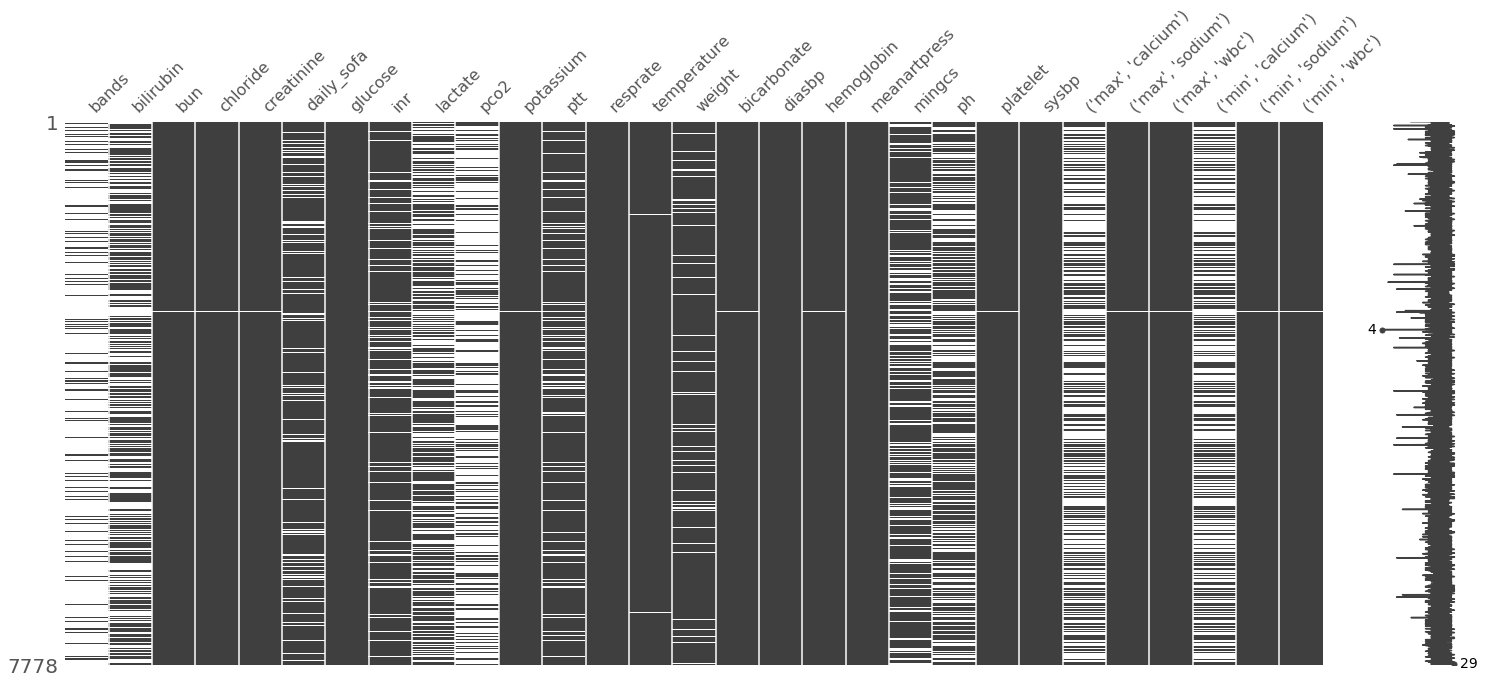

time: 659 ms


In [92]:
#train_df = pd.read_csv('train_2016_v2.csv', parse_dates=["transactiondate"])
#properties_df = pd.read_csv('properties_2016.csv')
#merged_df = pd.merge(train_df,properties_df)
missingdata_df = preImp.columns[preImp.isnull().any()].tolist()
msno.matrix(preImp[missingdata_df])

In [90]:
missingdata_df

['bands',
 'bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'daily_sofa',
 'glucose',
 'inr',
 'lactate',
 'pco2',
 'potassium',
 'ptt',
 'resprate',
 'temperature',
 'weight',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'ph',
 'platelet',
 'sysbp',
 "('max', 'calcium')",
 "('max', 'sodium')",
 "('max', 'wbc')",
 "('min', 'calcium')",
 "('min', 'sodium')",
 "('min', 'wbc')"]

time: 2.72 ms


In [94]:
preImp

,icustay_id,bands,bilirubin,bun,chloride,creatinine,daily_sofa,dobutamine,dopamine,epinephrine,...,"('min', 'calcium')","('min', 'sodium')","('min', 'wbc')",ethnicity,gender,leukocyte,nitrite,vent_recieved,final_bin,subject_id
0,200012.0,11.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,...,NaN,NaN,4.9,asian,F,Neg/Not_tested,Neg/Not_tested,None,C_neg/A_partial,28448
1,200014.0,NaN,NaN,24.0,114.0,0.8,2.0,0.0,0.0,0.0,...,1.13,138.0,10.7,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Mech,C_neg/A_partial,9514
2,200030.0,NaN,14.5,28.0,111.0,1.0,4.0,1.0,0.0,0.0,...,1.15,138.0,12.5,black,M,Neg/Not_tested,Neg/Not_tested,Oxygen,C_pos/A_full,14987
3,200033.0,NaN,NaN,16.0,108.0,0.7,1.0,0.0,0.0,0.0,...,1.03,133.0,6.2,white/nonhispanic,M,Neg/Not_tested,Neg/Not_tested,None,C_pos/A_full,56369
4,200036.0,NaN,NaN,31.0,110.0,1.0,1.0,0.0,0.0,0.0,...,NaN,136.0,4.3,white/nonhispanic,M,Neg/Not_tested,Neg/Not_tested,Oxygen,C_neg/A_partial,9960
5,200055.0,NaN,0.3,40.0,100.0,8.9,8.0,0.0,0.0,0.0,...,1.11,137.0,5.7,black,F,Neg/Not_tested,Neg/Not_tested,None,C_neg/A_partial,25225
6,200059.0,NaN,0.7,50.0,109.0,1.5,6.0,0.0,0.0,0.0,...,1.01,132.0,8.5,white/nonhispanic,F,Neg/Not_tested,Neg/Not_tested,None,C_neg/A_partial,28494
7,200061.0,NaN,5.9,15.0,106.0,0.9,3.0,0.0,0.0,0.0,...,NaN,137.0,11.5,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Oxygen,C_neg/A_partial,74282
8,200063.0,NaN,0.8,54.0,108.0,2.3,6.0,0.0,0.0,0.0,...,1.00,129.0,7.5,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Mech,C_neg/A_partial,99052
9,200075.0,NaN,3.1,9.0,110.0,0.6,4.0,0.0,0.0,0.0,...,NaN,135.0,10.1,white/nonhispanic,F,Neg/Not_tested,Neg/Not_tested,None,C_neg/A_partial,67800


time: 58.3 ms


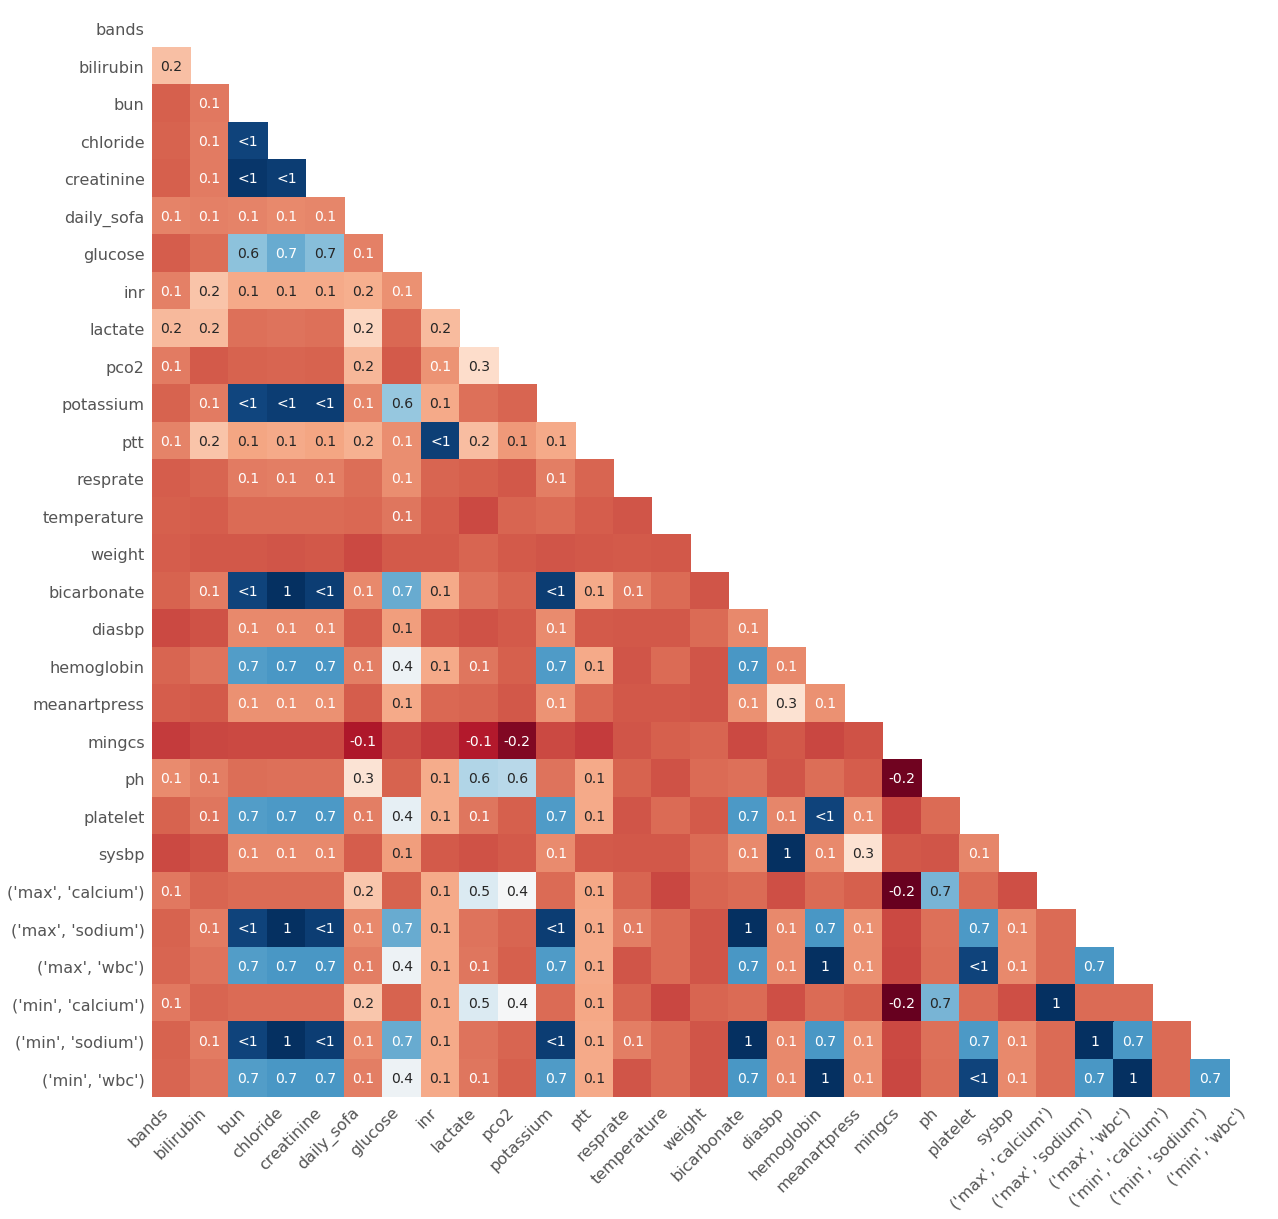

time: 1.56 s


In [93]:
#unclear of what this is

msno.heatmap(preImp[missingdata_df], figsize=(20,20))

MICE in python:
    
Multiple imputation is a process where the missing values are filled multiple times to create “complete” datasets. Multiple imputation has a lot of advantages over traditional single imputation methods. Multiple Imputation by Chained Equations (MICE) is an imputation method that works with the assumption that the missing data are Missing at Random (MAR). Recall that for MAR, the nature of the missing data is related to the observed data but not the missing data. The MICE algorithm works by running multiple regression models and each missing value is modeled conditionally depending on the observed (non-missing) values. A complete explanation of the MICE algorithm can be seen here. fancyimpute.MICE().complete(data matrix) can be used for MICE implementation.

https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87
This article highlights the importance of missing data in data science projects. It reviews exploration techniques and important imputation methods used for handling missing data. The other methods not described are model-based and machine learning based methods. Model-based methods assume a joint distribution of all the missing values in the model and estimate the model parameters describing the observed data. A wildly used model-based imputation method is a Pattern Mixture Model (PMM) trained with expectation-maximization (EM-) algorithm. Machine learning algorithms like eXtreme Gradient Boosting (xgboost) automatically learn the best imputation value for the missing data based on the training loss reduction.

advice on how to pool models in skl.
https://datascience.stackexchange.com/questions/23586/sklearn-aggregating-multiple-fitted-models-into-a-single-model-binary-classifi

In [96]:
from statsmodels import imputation

time: 14 ms


In [98]:
from sklearn.linear_model import LinearRegression
import skmice

imputer = MiceImputer()
X = [[1, 2], [np.nan, 3], [7, 6]]

X, specs = imputer.transform(X, LinearRegression, 10)

print (specs)

ModuleNotFoundError: No module named 'skmice'

time: 73.4 ms


last day before vacation, trying to:

* use ensemble to build multiple models,
* use a function to build many logistic regression models and compare
* test different models
* evaluate model.

# trying to make 2 regression models with imputed data sets and merge in ensemble

In [57]:
#model building code prior to wrapping in functions:

time: 568 µs


In [439]:
# #loading in csv
# x_train1= pd.read_csv(allFiles[0])#, index_col=0)
# x_train1= x_train1.iloc[:,1:]
# x_train2= pd.read_csv(allFiles[1])#, index_col=0)
# x_train2= x_train2.iloc[:,1:]

# #Ytrain
# y_train1= x_train1["final_bin"].values
# y_train2= x_train2["final_bin"].values
# ##binarizing y
# from sklearn.preprocessing import label_binarize
# y_true = label_binarize(y_train1, classes=['C_neg/A_partial', 'C_pos/A_full'])

# #XTRAIN
# ##dropping identifiers (subjectId &icustay_id, "final_bin")
# drop_cols=["subject_id", "icustay_id", "final_bin"]
# for element in drop_cols:
#     if element in list(x_train1):
#         x_train1=x_train1.drop(element,axis=1)

# for element in drop_cols:
#     if element in list(x_train2):
#         x_train2=x_train2.drop(element,axis=1)

# #for strings we can use pd.get_dummies() rather than onehotencoder below:
# cols_to_transform=['rrt', 'phenylephrine', 'norepinephrine', 'vasopressin', 'dobutamine', 'dopamine', 'epinephrine', 'leukocyte', 'vent_recieved', 'ethnicity','nitrite', 'gender']
# x_train1 = pd.get_dummies(x_train1, columns = cols_to_transform )
# x_train2 = pd.get_dummies(x_train2, columns = cols_to_transform )

# #binarizing y
# from sklearn.preprocessing import label_binarize
# y_true = label_binarize(y_train1, classes=['C_neg/A_partial', 'C_pos/A_full'])
# #n_classes = y_true.shape[1]

time: 183 ms


below is the last stuff i did before vacation, todo 1/7/18 (see bottom of notebook):  need to go through this code and:

* first need to evaluate the correlation matrix of variables pre and post imputation
* need to determine variables of most importance in models i build
* need to have a robust evaluation of model performance
* need to try cross validation

In [440]:
# # Learn to predict each class against the other

# ##instantiating model
# classifier = LogisticRegression()

# ##initializing model
# model_fit= classifier.fit(x_train1, np.ravel(y_true))

# ##confusion matrix
# confuse= confusion_matrix(classifier.predict(x_train1), np.ravel(y_true))

# ##scoring model based on true positive prediction rate and AUC.
# model_score= classifier.score(x_train1,np.ravel(y_true))
# auc_score= roc_auc_score(y_true, y_score)
# y_score = model_fit.decision_function(x_train1)

# #confusion_matrix(classifier.predict(x_train1),np.ravel(y_true))

# #roc_auc_score(logreg.predict(x_train1), y_true) #this is incorrect
# print("model fit:\n %s \n" % (model_fit),
#       "model score: %s \n" %(model_score),
#     "AUC: %s \n" % (roc_auc_score(y_true, y_score)),
#      "Confusion matrix: \n %s" %(confuse))

model fit:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 model score: 0.7954461990451708 
 AUC: 0.7991958287651808 
 Confusion matrix: 
 [[3797  867]
 [ 247  535]]
time: 502 ms


In [371]:
len(list(x_train1))

62

time: 1.77 ms


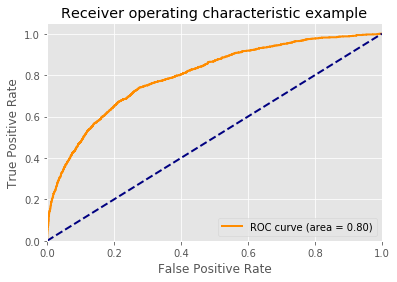

time: 141 ms


In [441]:
# roc_output= roc_curve(y_true,y_score)

# plt.figure()
# lw = 2
# plt.plot(roc_output[0], roc_output[1], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_true, y_score))
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [1]:
#so the value i'm getting out of this vs my roc_auc_score are different. (0.73 vs 0.71)
##need to dx this

###edit: this was fixed, can now proceed with the functions to test my code

In [52]:
def allFileRead(allFileIndex):
    testEnsDf1= pd.read_csv(allFiles[allFileIndex])#, index_col=0)
    testEnsDf1= testEnsDf1.iloc[:,1:] #removing the unknown value column
    
    return(testEnsDf1)

time: 2.49 ms


In [53]:
def preprocessing(testEnsDf1):
    from sklearn.preprocessing import label_binarize
    
    #enter in a dataframe with x's and y.
    x_train1=testEnsDf1.copy()
    
    #YTRUE
    ##seperate y from x's.   
    y_train1= x_train1["final_bin"].values
    ##convert string values into binary
    y_true = label_binarize(y_train1, classes=['C_neg/A_partial', 'C_pos/A_full']) #0 = neg, 1 = pos

    #XTRAIN
    ##dropping identifiers (subjectId &icustay_id)
    drop_cols=["subject_id", "icustay_id", "final_bin"]
    for element in drop_cols:
        if element in list(x_train1):
            x_train1=x_train1.drop(element,axis=1)
    
    ##for strings we can use pd.get_dummies() rather than onehotencoder below:
    cols_to_transform=['rrt', 'phenylephrine', 'norepinephrine', 'vasopressin', 'dobutamine', 'dopamine', 'epinephrine', 'leukocyte', 'vent_recieved', 'ethnicity','nitrite', 'gender']
    x_train1 = pd.get_dummies(x_train1, columns = cols_to_transform )
        
    return(x_train1, y_true)

time: 14.1 ms


In [58]:
def modelAUC(allFileIndex, classFxn="logit"):
    from sklearn.metrics import roc_curve, auc
    
    x_train, y_true = preprocessing(allFileIndex)
    
    
    if classFxn=="logit": 
        classifier= LogisticRegression()
            # Learn to predict each class against the other

        ##initializing model
        model_fit= classifier.fit(x_train, np.ravel(y_true))

        ##confusion matrix
        confuse= confusion_matrix(classifier.predict(x_train),np.ravel(y_true))

        ##scoring model based on true positive prediction rate and AUC.
        model_score= classifier.score(x_train,np.ravel(y_true))
        #y_score = model_fit.decision_function(x_train)
        y_score = model_fit.predict_proba(x_train)[:,1]
        auc_score= roc_auc_score(y_true, y_score)
        
    elif classFxn=="randomforest":
        classifier= RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)

        ##initializing model
        model_fit= classifier.fit(x_train, np.ravel(y_true))

        ##confusion matrix
        confuse= confusion_matrix(classifier.predict(x_train),np.ravel(y_true))

        ##scoring model based on true positive prediction rate and AUC.
        model_score= classifier.score(x_train,np.ravel(y_true))
        y_score = model_fit.predict_proba(x_train)[:,1]
        #print(y_score)
        auc_score= roc_auc_score(y_true, y_score)
        print(classifier.feature_importances_)
        

    """
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class, confidence values, 
        or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).

    """
    #roc_auc_score(logreg.predict(x_train), y_true) #this is incorrect
    print("model fit:\n %s \n" % (model_fit),
          "model score: %s \n" %(model_score),
        "AUC: %s \n" % (roc_auc_score(y_true, y_score)),
         "Confusion matrix: \n %s" %(confuse))

    roc_output= roc_curve(y_true,y_score)

    plt.figure()
    lw = 2
    plt.plot(roc_output[0], roc_output[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_true, y_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


time: 82.4 ms


model fit:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 model score: 0.7954094748439221 
 AUC: 0.7989803865750638 
 Confusion matrix: 
 [[75964 17368]
 [ 4916 10672]]


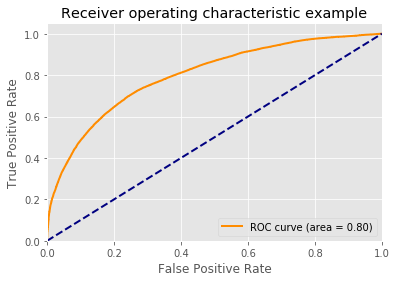

time: 11.1 s


In [59]:
modelAUC(imputeCat_df)

model fit:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 model score: 0.7963643040763864 
 AUC: 0.800477557142474 
 Confusion matrix: 
 [[3803  868]
 [ 241  534]]


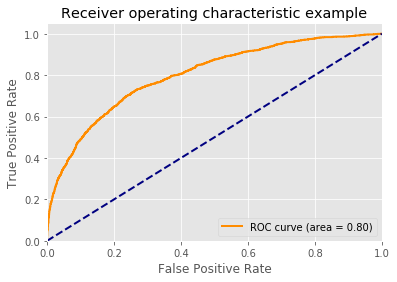

time: 582 ms


In [60]:
modelAUC(imputeMean_df)

model fit:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 model score: 0.7954461990451708 
 AUC: 0.799181718641308 
 Confusion matrix: 
 [[3797  867]
 [ 247  535]]


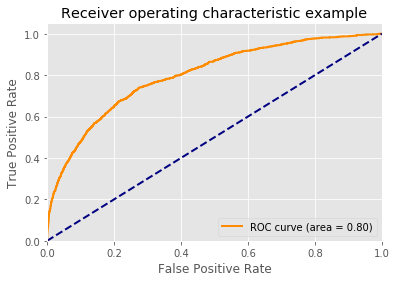

time: 594 ms


In [61]:
modelAUC(allFileRead(0))

[0.         0.00114569 0.01453792 0.         0.00127572 0.15245186
 0.00086067 0.         0.04702957 0.01119613 0.02802891 0.00157935
 0.         0.00034027 0.02256738 0.07153879 0.         0.03521786
 0.01027798 0.00051663 0.01521248 0.01279055 0.05530669 0.01699716
 0.01050522 0.02981424 0.08721124 0.         0.         0.03204198
 0.00057994 0.00060383 0.00602783 0.         0.         0.
 0.         0.11272007 0.09272373 0.         0.00413116 0.00043432
 0.         0.         0.         0.         0.         0.0366508
 0.07223516 0.         0.         0.         0.         0.
 0.         0.         0.         0.01003598 0.00541291 0.
 0.        ]
model fit:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,


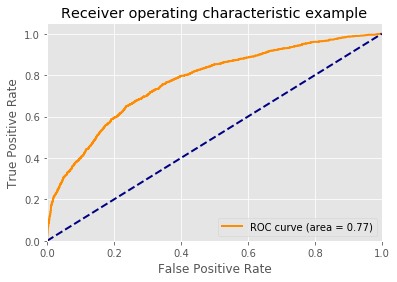

time: 558 ms


In [65]:
modelAUC(allFileRead(0), classFxn="randomforest")


,icustay_id,bands,bilirubin,bun,chloride,creatinine,daily_sofa,dobutamine,dopamine,epinephrine,...,"('max', 'wbc')","('min', 'calcium')","('min', 'sodium')","('min', 'wbc')",ethnicity,gender,leukocyte,nitrite,vent_recieved,final_bin
0,200012.0,11.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,...,4.9,NaN,NaN,4.9,asian,F,Neg/Not_tested,Neg/Not_tested,None,C_neg/A_partial
1,200014.0,NaN,NaN,24.0,114.0,0.8,2.0,0.0,0.0,0.0,...,14.3,1.13,138.0,10.7,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Mech,C_neg/A_partial
2,200030.0,NaN,14.5,28.0,111.0,1.0,4.0,1.0,0.0,0.0,...,13.9,1.15,138.0,12.5,black,M,Neg/Not_tested,Neg/Not_tested,Oxygen,C_pos/A_full
3,200033.0,NaN,NaN,16.0,108.0,0.7,1.0,0.0,0.0,0.0,...,7.7,1.03,133.0,6.2,white/nonhispanic,M,Neg/Not_tested,Neg/Not_tested,None,C_pos/A_full
4,200036.0,NaN,NaN,31.0,110.0,1.0,1.0,0.0,0.0,0.0,...,6.7,NaN,136.0,4.3,white/nonhispanic,M,Neg/Not_tested,Neg/Not_tested,Oxygen,C_neg/A_partial
5,200055.0,NaN,0.3,40.0,100.0,8.9,8.0,0.0,0.0,0.0,...,6.3,1.11,137.0,5.7,black,F,Neg/Not_tested,Neg/Not_tested,None,C_neg/A_partial
6,200059.0,NaN,0.7,50.0,109.0,1.5,6.0,0.0,0.0,0.0,...,14.8,1.01,132.0,8.5,white/nonhispanic,F,Neg/Not_tested,Neg/Not_tested,None,C_neg/A_partial
7,200061.0,NaN,5.9,15.0,106.0,0.9,3.0,0.0,0.0,0.0,...,15.6,NaN,137.0,11.5,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Oxygen,C_neg/A_partial
8,200063.0,NaN,0.8,54.0,108.0,2.3,6.0,0.0,0.0,0.0,...,8.1,1.00,129.0,7.5,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Mech,C_neg/A_partial
9,200075.0,NaN,3.1,9.0,110.0,0.6,4.0,0.0,0.0,0.0,...,17.3,NaN,135.0,10.1,white/nonhispanic,F,Neg/Not_tested,Neg/Not_tested,None,C_neg/A_partial


time: 81.6 ms


In [467]:
y_score

array([-1.5354067 , -1.08129551, -2.06383623, ..., -1.45741995,
        0.17838293, -2.30416815])

time: 1.97 ms


In [543]:
X, y = preprocessing(allFileRead(0))

time: 90 ms


In [545]:
X, y = preprocessing(allFileRead(0))
X= X.values
X=X[:, [0, 2]]

AttributeError: 'numpy.ndarray' object has no attribute 'values'

time: 7.52 ms


In [548]:
X=X[:, [0, 2]]

time: 855 µs


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time: 9.18 s


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


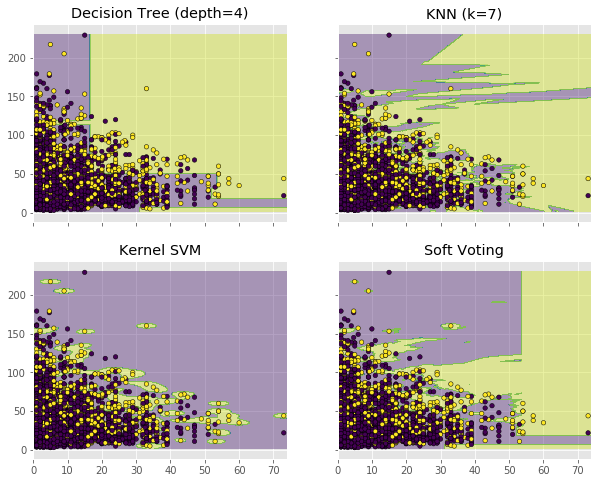

time: 3min 6s


In [571]:

X, y, y2 = preprocessing(allFileRead(0))
X= X.values
X=X[:, [0, 2]]
y3= pd.get_dummies(y2)["C_pos/A_full"].values

y=y3
# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)', 'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

ValueError: Number of features of the model must match the input. Model n_features is 61 and input n_features is 2 

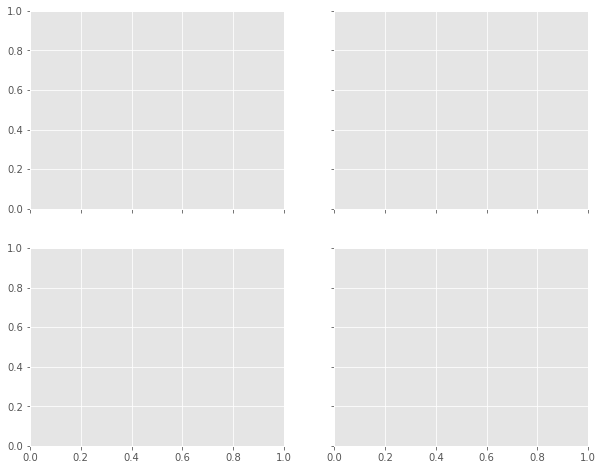

time: 25.8 s


In [577]:

X, y, y2 = preprocessing(allFileRead(0))
X= X.values
X=X#[:, [0, 2]]
y3= pd.get_dummies(y2)["C_pos/A_full"].values

y=y3
# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)', 'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [609]:
X, y = preprocessing(allFileRead(0))
X= X.values
X2=X[:, [0, 2]]
X[:, 0]

array([ 1., 11.,  1., ..., 28.,  2.,  1.])

time: 90.3 ms


In [584]:
X[:, [0, 2]] #this is column 0 and 2

array([[ 1., 24.],
       [11., 28.],
       [ 1., 16.],
       ...,
       [28., 45.],
       [ 2., 52.],
       [ 1.,  6.]])

time: 2.59 ms


In [592]:
X[:,2]

array([24., 28., 16., ..., 45., 52.,  6.])

time: 2.98 ms


In [576]:
for element in zip(product([0, 1], [0, 1]),[clf1, clf2, clf3, eclf],['Decision Tree (depth=4)', 'KNN (k=7)', 'Kernel SVM', 'Soft Voting']):
    print(element)

((0, 0), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'Decision Tree (depth=4)')
((0, 1), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform'), 'KNN (k=7)')
((1, 0), SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'Kernel SVM')
((1, 1), VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            mi

In [593]:
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

time: 7.56 ms


In [570]:
y3= pd.get_dummies(y2)["C_pos/A_full"].values

time: 2.31 ms


In [563]:
def preprocessing(testEnsDf1):
    from sklearn.preprocessing import label_binarize
    
    #enter in a dataframe with x's and y.
    x_train1=testEnsDf1.copy()
    
    #YTRUE
    ##seperate y from x's.   
    y_train1= x_train1["final_bin"].values
    ##convert string values into binary
    y_true = label_binarize(y_train1, classes=['C_neg/A_partial', 'C_pos/A_full']) #0 = neg, 1 = pos

    #XTRAIN
    ##dropping identifiers (subjectId &icustay_id)
    drop_cols=["subject_id", "icustay_id", "final_bin"]
    for element in drop_cols:
        if element in list(x_train1):
            x_train1=x_train1.drop(element,axis=1)
    
    ##for strings we can use pd.get_dummies() rather than onehotencoder below:
    cols_to_transform=['rrt', 'phenylephrine', 'norepinephrine', 'vasopressin', 'dobutamine', 'dopamine', 'epinephrine', 'leukocyte', 'vent_recieved', 'ethnicity','nitrite', 'gender']
    x_train1 = pd.get_dummies(x_train1, columns = cols_to_transform )
        
    return(x_train1, y_true, y_train1)

time: 16.2 ms


# would like to redo the decision boundary stuff with the 2-3 most impactful parameters. need to do feature selection

In [612]:
#feature select

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
# iris = load_iris()
# X, y = iris.data, iris.target
#  X.shape
# (150, 4)
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X_new.shape               


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


(5446, 35)

time: 385 ms


In [614]:
clf.feature_importances_  

array([0.02207416, 0.02079418, 0.02540213, 0.02037441, 0.02057902,
       0.03550503, 0.02001104, 0.02103822, 0.02865958, 0.02129284,
       0.02345266, 0.02093897, 0.02078823, 0.02163121, 0.02837103,
       0.03333121, 0.02090988, 0.02513018, 0.02192613, 0.02197159,
       0.02433676, 0.02499284, 0.02164066, 0.02265115, 0.02133547,
       0.02487035, 0.02889304, 0.02002072, 0.02211816, 0.02331861,
       0.02146932, 0.02153232, 0.02322981, 0.00487224, 0.00544736,
       0.00741587, 0.00751209, 0.02151712, 0.02293936, 0.0045349 ,
       0.00435287, 0.00178568, 0.00155682, 0.0037089 , 0.00461446,
       0.00284569, 0.00251236, 0.01579497, 0.01308572, 0.01063171,
       0.01022839, 0.00840773, 0.00437173, 0.00722428, 0.00460232,
       0.00780823, 0.01042626, 0.00674235, 0.00843017, 0.01070908,
       0.01133045])

time: 7.79 ms


In [ ]:
# plt.figure()
# lw = 2
# plt.plot(fpr[0], tpr[0], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
# from sklearn.metrics import roc_curve, auc
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# BACK FROM VACATION

above is the last stuff i did before vacation, todo 1/7/18: need to go through this code and:

* first need to evaluate the correlation matrix of variables pre and post imputation
* need to determine variables of most importance in models i build
* need to have a robust evaluation of model performance
* need to try cross validation

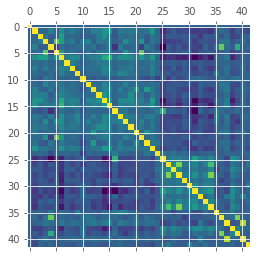

time: 183 ms


In [66]:
import matplotlib.pyplot as plt

plt.matshow(preImp.corr())

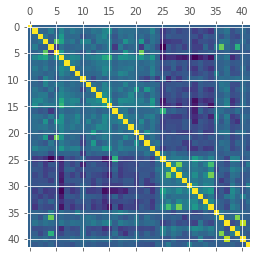

time: 193 ms


In [67]:
plt.matshow(allFileRead(0).corr())

In [69]:
list(allFileRead(0))

['icustay_id',
 'bandsNum',
 'bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'daily_sofa',
 'dobutamine',
 'dopamine',
 'epinephrine',
 'first_admit_age',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'norepinephrine',
 'pco2',
 'phenylephrine',
 'potassium',
 'ptt',
 'resprate',
 'rrt',
 'temperature',
 'vasopressin',
 'weight',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2Ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'maxCalcium',
 'maxSodium',
 'maxWBC',
 'minCalcium',
 'minSodium',
 'minWBC',
 'ethnicity',
 'gender',
 'leukocyte',
 'nitrite',
 'vent_recieved',
 'subject_id',
 'final_bin']

time: 42.2 ms


In [76]:
zero_train, zero_true= preprocessing(allFileRead(0))

time: 67.1 ms


In [78]:
zero_train['final_bin']= zero_true

time: 1.46 ms


In [91]:
zero_train.corr()['final_bin'].sort_values(ascending=False).head(10)

final_bin              1.000000
daily_sofa             0.287393
norepinephrine_True    0.254484
temperature            0.227232
heartrate              0.222748
resprate               0.209798
lactate                0.200269
leukocyte_pos          0.196068
bun                    0.178828
maxWBC                 0.157500
Name: final_bin, dtype: float64

time: 33.1 ms


In [92]:
zero_train.corr()['final_bin'].sort_values(ascending=False).tail(10)

pao2fio2Ratio              -0.166322
mingcs                     -0.173488
ph                         -0.175523
diasbp                     -0.179062
bicarbonate                -0.181242
spo2                       -0.187062
leukocyte_Neg/Not_tested   -0.196068
meanartpress               -0.216401
sysbp                      -0.245210
norepinephrine_False       -0.254484
Name: final_bin, dtype: float64

time: 33.9 ms


In [75]:
allFileRead(0).corr()

,icustay_id,bandsNum,bilirubin,bun,chloride,creatinine,daily_sofa,dobutamine,dopamine,epinephrine,...,platelet,spo2,sysbp,maxCalcium,maxSodium,maxWBC,minCalcium,minSodium,minWBC,subject_id
icustay_id,1.000000,-0.007177,-0.006021,0.009171,-0.009148,-0.008814,0.009361,0.010305,-0.005719,0.002830,...,-0.015754,-0.014631,-0.006708,0.009404,-0.009066,0.004045,-0.004854,-0.019170,-0.000824,0.009031
bandsNum,-0.007177,1.000000,0.035814,0.024070,0.155736,0.010918,0.203231,0.056097,0.140929,0.072971,...,-0.116820,-0.153011,-0.227790,0.021872,0.036844,0.100785,-0.100015,-0.014987,0.047734,-0.042838
bilirubin,-0.006021,0.035814,1.000000,0.102787,-0.018582,0.065333,0.329261,0.039532,0.041246,0.044910,...,-0.187782,-0.025103,-0.080934,0.003422,-0.079462,0.035819,-0.100175,-0.143273,0.005063,0.000424
bun,0.009171,0.024070,0.102787,1.000000,-0.016474,0.635593,0.391705,0.072520,0.132191,0.006256,...,-0.102540,-0.090252,-0.127892,-0.034027,0.115367,0.095927,-0.069455,-0.020141,0.063554,-0.045821
chloride,-0.009148,0.155736,-0.018582,-0.016474,1.000000,-0.176574,0.088667,0.000072,0.018883,0.047969,...,-0.183581,0.026067,-0.136024,0.160321,0.671620,0.050176,-0.046103,0.473061,-0.011734,0.022577
creatinine,-0.008814,0.010918,0.065333,0.635593,-0.176574,1.000000,0.335307,0.031939,0.079986,0.010264,...,-0.081325,-0.062581,-0.025689,-0.056444,-0.020154,0.011735,-0.093327,-0.094937,-0.011512,-0.062357
daily_sofa,0.009361,0.203231,0.329261,0.391705,0.088667,0.335307,1.000000,0.154946,0.237076,0.203189,...,-0.340642,-0.245213,-0.390410,0.076661,0.028034,0.116446,-0.285085,-0.140179,0.000498,-0.024874
dobutamine,0.010305,0.056097,0.039532,0.072520,0.000072,0.031939,0.154946,1.000000,0.157494,0.100768,...,-0.034572,-0.125598,-0.117287,0.000214,-0.005211,0.034560,-0.054390,-0.035822,0.006698,-0.043459
dopamine,-0.005719,0.140929,0.041246,0.132191,0.018883,0.079986,0.237076,0.157494,1.000000,0.028369,...,-0.055004,-0.148880,-0.230045,-0.015579,0.001766,0.085890,-0.122053,-0.056651,0.063459,-0.088544
epinephrine,0.002830,0.072971,0.044910,0.006256,0.047969,0.010264,0.203189,0.100768,0.028369,1.000000,...,-0.103144,-0.054108,-0.124739,0.170520,-0.030610,0.067732,-0.098644,-0.086700,0.020565,-0.009638


time: 104 ms
